* Submission: [Athon Millane](https://www.linkedin.com/in/athon-millane/)
* Email: [athon@sadana.dev](mailto:athon@sadana.dev)
* Paper: [When Do Stop-Loss Rules Stop Losses?](https://dspace.mit.edu/bitstream/handle/1721.1/114876/Lo_When%20Do%20Stop-Loss.pdf)

# Implementation of a Stop Loss Policy with Empirical Results

## Introduction
This notebook demonstrates an implementation of the Stop Loss Policy from the paper, *When Do Stop-Loss Rules Stop Losses?*, Kaminski, Lo.

In the paper, the authors define a simple Stop-Loss Policy $\mathcal{S}(\gamma, \delta, J, \kappa)$ for a portfolio strategy $P$ with returns $\{r_t\}$. This is a dynamic binary asset-allocation rule $\{s_t\}$ between $P$ and a risk-free asset $F$ with return $r_f$ , where $s_t$ is the proportion of assets allocated to $P$, and:

$s_{t} \equiv\left\{\begin{array}{llllll}0 & \text { if } & R_{t-1}(J) & <-\gamma & \text { and } & s_{t-1}=1 & \text { (exit) } \\ 1 & \text { if } & r_{t-1} & \geq \delta & \text { and } & s_{t-1}=0 & \text { (re-enter) } \\ 1 & \text { if } & R_{t-1}(J) & \geq-\gamma & \text { and } & s_{t-1}=1 & \text { (stay in) } \\ 0 & \text { if } & r_{t-1} & <\delta & \text { and } & s_{t-1}=0 & \text { (stay out) }\end{array}\right.$

For $\gamma \geq 0$. 

The authors denote by $r_st$ the return of portfolio strategy $S$, which is the combinaton of portfolio strategy $P$ and the stop-loss policy $S$, hence:

$r_{s t} \equiv s_{t} r_{t}+\left(1-s_{t}\right) r_{f}$.

---

To begin, we load in S&P500 constituents data and construct a cleaned returns portfolio for experimentation.

In [1]:
from data.utils import pull_sp500, load_sp500

pull_sp500()
returns_df = load_sp500()

returns_df.head()

,r_t
Date,
2001-01-03,0.037104
2001-01-04,-0.015840
2001-01-05,-0.021514
2001-01-08,0.000993
2001-01-09,0.001583


We now instantiate a new `StopLossPolicy` $\mathcal{S}(\gamma, \delta, J, \kappa=0)$ and apply it to the Portfolio of returns. Plot shows one-period return $r_{t-1}$ as compared to a constant re-entry threshold $\delta$, and J-period cumulative Return $R_t(J)$ as compared to stopping threshold $\gamma$. Resultant policy state over time $s_t$ is displayed.

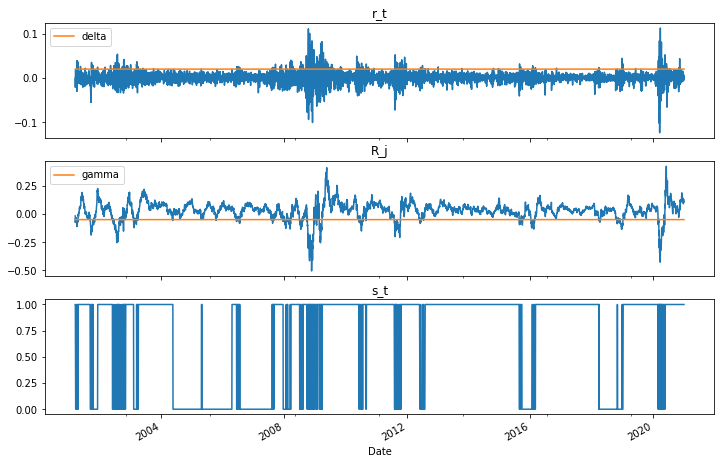

In [2]:
from stop_loss_policy import StopLossPolicy

sl = StopLossPolicy(returns_df)

params = {"gamma":-0.05, "delta":0.02, "j":50}

sl.calculate(**params)
sl.visualise(show_params=True)

We may now apply the calculated policy, visualise returns $r_t$ and $r_{st}$ and calculate empirical performance measures from these returns. Performance measures of interest are presented in definitions 2 and 3 of the paper and are summarised here:

1. Stopping premium: $\Delta_{\mu}(\mathcal{S}) \equiv \mathrm{E}\left[r_{s t}\right]-\mathrm{E}\left[r_{t}\right]$
2. Stopping ratio: $\frac{\Delta_{\mu}}{p_{o}}=r_{f}-\mathrm{E}\left[r_{t} \mid s_{t}=0\right]$
3. Variance difference: $\Delta_{\sigma^{2}} \equiv \operatorname{Var}\left[r_{s t}\right]-\operatorname{Var}\left[r_{t}\right]$
4. Standard Deviation difference: $\Delta_{\sigma} \equiv \sqrt{\operatorname{Var}\left[r_{s t}\right]}-\sigma$
5. Sharpe Difference: $\Delta_{\mathrm{SR}} \equiv \frac{\mathrm{E}\left[r_{s t}\right]-r_{f}}{\sigma_{s}}-\frac{\mu-r_{f}}{\sigma}$

In these calculations, we use a constant default risk-free return of $r_f = 0$, however this return could be replaced with a dynamic $r_f$ derived from an alternative portfolio.

,0,1
0,Stopping Premium,-0.000313
1,Stopping Ratio,-0.001003
2,Variance Difference,-0.000087
3,Standard Deviation Difference,-0.003885
4,Sharpe Difference,-0.015069


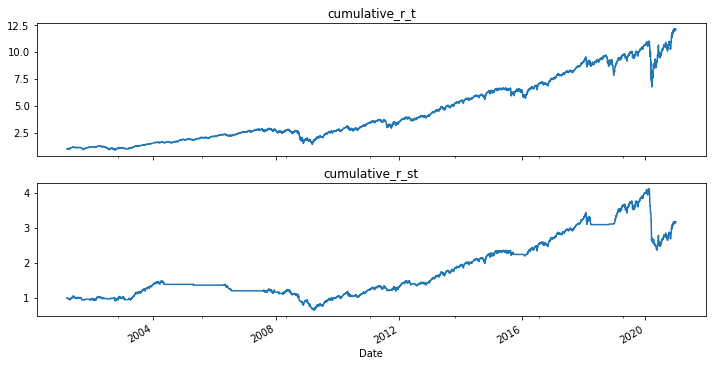

In [3]:
sl.apply()
sl.visualise_returns(compounding=True) # Use compounding version of returns.
sl.calculate_performance_measures()

We see that the stopping policy is unfortunately too late to respond to major market events at the daily scale, and then misses out on the market bouncing back the following day because it is already stopped out at a low point.

To properly ameleriate this issue, a shorter time period would likely be necessary to allow for faster reaction to market conitions. To investigate whether better parameters can be found at the daily timeframe, we implement a parameter sweep.

### Vectorised implementation
Our API provides a JIT compiled implementation, shown here to provide a **70x** speed up over serial policy iteration.

In [4]:
%timeit sl.calculate(**params, vectorised=False)
%timeit sl.calculate(**params)

130 ms ± 1.45 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
1.7 ms ± 11.4 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


---

## Parameter Sweep
In this section, we run a comprehensive parameter sweep across all parameters of the process: $(\gamma, \delta, J, \kappa)$.

While the paper does not factor a return penalty $\kappa$ into empirical modelling, this is useful for realistic modelling of returns with a stop loss and is defined as: $r_{s t} \equiv s_{t} r_{t}+\left(1-s_{t}\right) r_{f}-\kappa\left|s_{t}-s_{t-1}\right|$.

  0%|          | 0/400 [00:00<?, ?it/s]

Best policy for metric Stopping Ratio:


,Value
gamma,-1.50000
delta,2.00000
j,10.00000
kappa,0.00100
Stopping Ratio,-0.00054


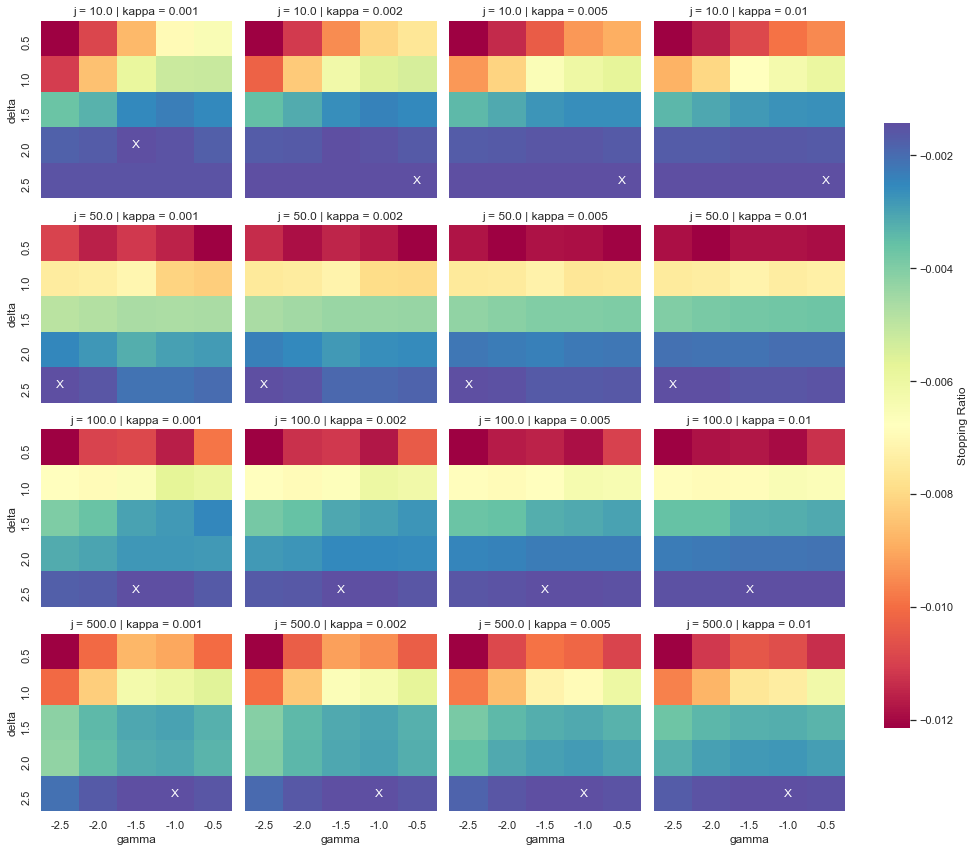

In [5]:
from parameter_sweep import ParameterSweep

ps = ParameterSweep(returns_df)

sweep_params = {
    "gamma": [-2.5, -2, -1.5, -1, -0.5],
    "delta": [0.5, 1, 1.5, 2, 2.5],
    "j":     [10, 50, 100, 500],
    "kappa": [0.001, 0.002, 0.005, 0.01]
}

metric = "Stopping Ratio"

best_params = ps.sweep_policy(sweep_params, metric)

Takeaways from this sweep are that unfortunately, outcomes on this portfolio are not improved for any set of process parameters, however results do come close to zero impact in some parameter configurations. This is consistent with the portfolio returns being closer to a Random Walk process than an AR(1).
We see that for the Stopping Ratio, $\delta$ strongly influences quality of the results. This makes sense because with an underperforming policy, higher $\delta$ will result in less time stopped out of the and missing out on positive returns.

We now investigate further into the best parameter configuration from the sweep.

,0,1
0,Stopping Premium,-0.000436
1,Stopping Ratio,-0.000540
2,Variance Difference,-0.000152
3,Standard Deviation Difference,-0.008657
4,Sharpe Difference,-0.012845


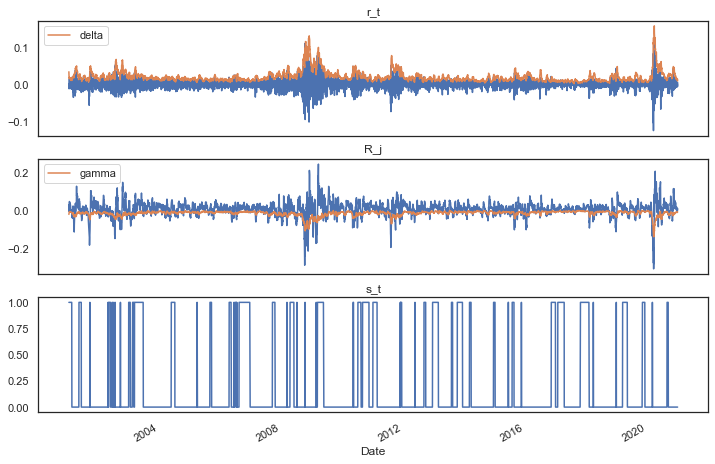

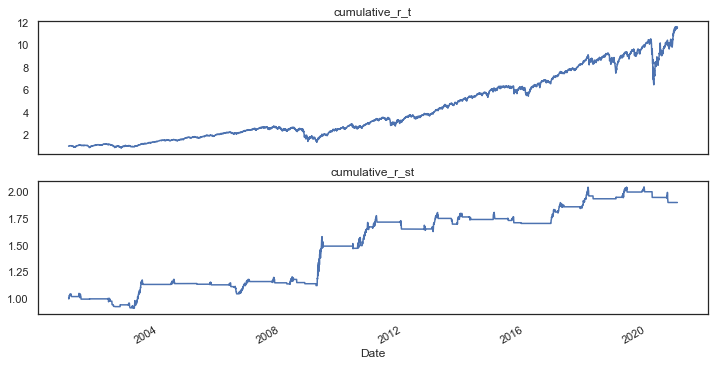

In [6]:
params = best_params
params

sl.calculate(**params)
sl.visualise(show_params=True)
sl.apply(r_f=0)
sl.visualise_returns(compounding=True)
sl.calculate_performance_measures()

The policy found is interesting in that it seems to be able to capitalise on a combination of high $\delta$ and relatively low $\gamma$. This policy stays stopped out for extreme market crashes and only reenters in periods of very high growth. While cumulative returns are far lower, they are also much closer to monotonic which may be more desirable in risk averse market conditions. Notably however, the Sharpe Difference is still negative suggesting even risk adjusted performance is worse than the Portfolio policy.

---

## Results on Simulated AR(1) Processes

Here, we generate a series of AR(1) process observations (Equation 14 in the paper) with different rho values and prove empirically that a momentum strategy will benefit from a stop-loss rule, whereas a mean-reverting strategy will not.

Each metric of interest is derived for 100 process realisations, each of length N=1000. Results of performance measures (with $1\sigma$ confidence interval on each measure) are visualised below.

  0%|          | 0/38 [00:00<?, ?it/s]

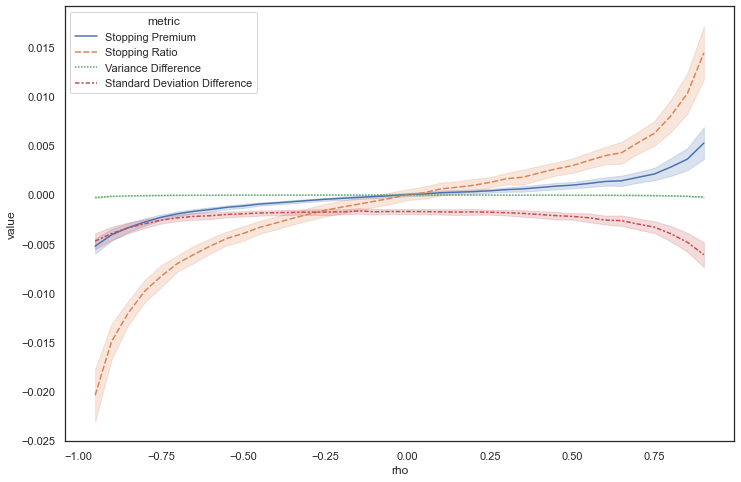

In [7]:
import numpy as np
rhos = np.arange(-0.95,0.95,0.05)

ps.sweep_ar1(rhos)

---

## Empirical Analysis from Paper
In Section 5 of the paper, an empirical analysis is completed on futures markets from 1993 to 2011. These markets are favoured because they have high serial autocorrelation and a momentum tendency. Here we use the S&P500 constituents already shown to not be as amenable to the stop loss process, however Figures 3-5 are recreated on our returns portfolio.

  0%|          | 0/5 [00:00<?, ?it/s]

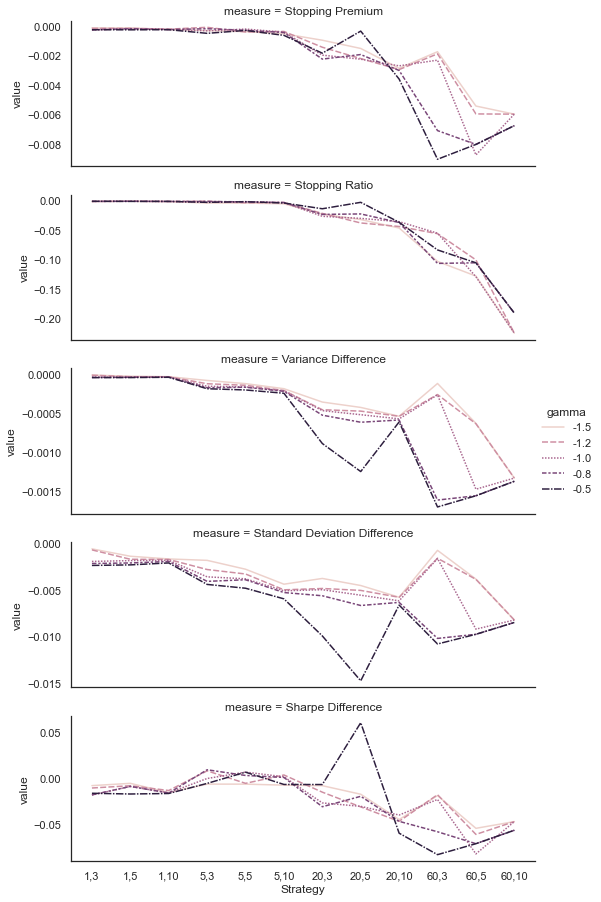

In [8]:
sweep_params = {
    "resample": [1, 5, 20, 60],
    "J": [3, 5, 10],
    "gamma": [-1.5, -1.2, -1.0, -0.8, -0.5],
    "delta": [0]
}

ps.sweep_paper(sweep_params, metric)

---

## Conclusion

This notebook demonstrated an implementation of a simple stop-loss policy applied to historical and simulated portfolios. In experiments with a uniformly distributed portfolio of S&P500 constituents, the policy portfolio does not outperform the default portfolio strategy. 

That said, Monte Carlo samples of an AR(1) process are highly consistent with the analytical results of the paper, and show that in momentum scenarios $(\rho = (0,1))$ and for reasonable stop loss parameters, $\eta(\gamma, \delta, J) \geq 0$.

## References
1. Kaminski, Kathryn M., and Andrew W. Lo. “When Do Stop-Loss Rules Stop Losses?” Journal of Financial Markets 18 (March 2014). Available at: https://dspace.mit.edu/bitstream/handle/1721.1/114876/Lo_When%20Do%20Stop-Loss.pdf

---